In [394]:
# model.py

import torch
from torch.nn import functional as F
import torch.nn as nn
import networkx as nx
import numpy as np

from typing import Optional, Dict, List, Tuple, Union
# 1. introduce dag into attention -> include transpose to help with routing
# 2. introduce diagonal after first layer
# 3. handle skip connection masking issue
        
# note that the network has MHA with blocks in parallel, but this is also done sequentially, combining
# both network width and network depth.

# for the causal transformer, we have to be careful that we include a 'diagonal' pass-thru after the first layer
# otherwise, and e.g. in a three variable chain A->B->C, the dependency structure will prevent B from being predicted
# from A <after the first layer>, because B is caused by A, not by itself. So the diagonal of ones should be
# introduced after the first layer.

In [405]:
## datasets.py
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt


def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))


def reorder_dag(dag):
    '''Takes a networkx digraph object and returns a topologically sorted graph.'''

    assert nx.is_directed_acyclic_graph(dag), 'Graph needs to be acyclic.'

    old_ordering = list(dag.nodes())  # get old ordering of nodes
    adj_mat = nx.to_numpy_array(dag)  # get adjacency matrix of old graph

    index_old = {v: i for i, v in enumerate(old_ordering)}
    topological_ordering = list(nx.topological_sort(dag))  # get ideal topological ordering of nodes

    permutation_vector = [index_old[v] for v in topological_ordering]  # get required permutation of old ordering

    reordered_adj = adj_mat[np.ix_(permutation_vector, permutation_vector)]  # reorder old adj. mat

    dag = nx.from_numpy_array(reordered_adj, create_using=nx.DiGraph)  # overwrite original dag

    mapping = dict(zip(dag, topological_ordering))  # assign node names
    dag = nx.relabel_nodes(dag, mapping)

    return dag


def get_full_ordering(DAG):
    ''' Note that the input DAG MUST be topologically sorted <before> using this function'''
    ordering_info = {}
    current_level = 0
    var_names = list(DAG.nodes)

    for i, var_name in enumerate(var_names):

        if i == 0:  # if first in list
            ordering_info[var_name] = 0

        else:
            # check if any parents
            parent_list = list(DAG.predecessors(var_name))

            # if no parents ()
            if len(parent_list) == 0:
                ordering_info[var_name] = current_level

            elif len(parent_list) >= 1:  # if some parents, find most downstream parent and add 1 to ordering
                for parent_var in parent_list:
                    parent_var_order = ordering_info[parent_var]
                    ordering_info[var_name] = parent_var_order + 1

    return ordering_info


def generate_data(N, seed, dataset, standardize=1):
    '''
    :param N: required sample size
    :param seed: random seed
    :param dataset: which dataset to use (only 'general' currently implemented)
    :return: data (DxN), a DAG (networkX), a list of variable names, Y0 and Y1 (vectors of counterfactual outcomes), a list of variable types

    Note that the data, the DAG, and the variable names are topologically sorted.
    '''

    np.random.seed(seed=seed)
    DAGnx = nx.DiGraph()
    if dataset == 'general':
        # confounders
        z1 = np.random.binomial(1, 0.5, (N, 1))
        z2 = np.random.binomial(1, 0.65, (N, 1))
        z3 = np.round(np.random.uniform(0, 4, (N, 1)), 0)
        z4 = np.round(np.random.uniform(0, 5, (N, 1)), 0)
        uz5 = np.random.randn(N, 1)
        z5 = 0.2 * z1 + uz5

        # risk vars:
        r1 = np.random.randn(N, 1)
        r2 = np.random.randn(N, 1)

        # instrumental vars:
        i1 = np.random.randn(N, 1)
        i2 = np.random.randn(N, 1)

        # treatment:
        ux = np.random.randn(N, 1)
        xp = sigm(-5 + 0.05 * z2 + 0.25 * z3 + 0.6 * z4 + 0.4 * z2 * z4 + 0.15 * z5 + 0.1 * i1 + 0.15 * i2 + 0.1 * ux)
        X = np.random.binomial(1, xp, (N, 1))

        # mediator:
        Um = np.random.randn(N, 1)
        m1 = 0.8 + 0.15 * Um
        m0 = 0.15 * Um


        if standardize:
            z1 = (z1 - z1.mean() )/ z1.std()
            z2 = (z2 - z2.mean()) / z2.std()
            z3 = (z3 - z3.mean()) / z3.std()
            z4 = (z4 - z4.mean()) / z4.std()
            z5 = (z5 - z5.mean()) / z5.std()

            r1 = (r1 - r1.mean()) / r1.std()
            r2 = (r2 - r2.mean()) / r2.std()

            i1 = (i1 - i1.mean()) / i1.std()
            i2 = (i2 - i2.mean()) / i2.std()

            X = (X - X.mean()) / X.std()

            m1 = (m1 - m1.mean()) / m1.std()
            m0 = (m0 - m0.mean()) / m0.std()

        M = m1 * X + m0 * (1 - X)

        if standardize:
            M = (M - M.mean() ) / M.std()
        # outcomes:
        Y1 = np.random.binomial(1, sigm(np.exp(-1 + m1 - 0.1 * z1 + 0.35 * z2 +
                                               0.25 * z3 + 0.2 * z4 + 0.15 * z2 * z4 + r1 + r2)),
                                (N, 1))
        Y0 = np.random.binomial(1,
                                sigm(-1 + m0 - 0.1 * z1 + 0.35 * z2 + 0.25 * z3 + 0.2 * z4 + 0.15 * z2 * z4 + r1 + r2),
                                (N, 1))
        Y = Y1 * X + Y0 * (1 - X)

        if standardize:
            Y = (Y - Y.mean() ) / Y.std()

        # colliders:
        C = 0.6 * Y + 0.4 * X + 0.4 * np.random.randn(N, 1)

        all_data_dict = {'Z1': z1, 'Z2': z2, 'Z3': z3, 'Z4': z4, 'Z5': z5, 'X': X, 'M': M, 'I1': i1,
                         'I2': i2, 'R1': r1, 'R2': r2, 'Y': Y, 'C': C}

        # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
        var_types = {'Z1': 'cont', 'Z2': 'cont', 'Z3': 'cont', 'Z4': 'cont', 'Z5': 'cont', 'X': 'bin', 'M': 'cont', 'I1': 'cont',
                         'I2': 'cont', 'R1': 'cont', 'R2': 'cont', 'Y': 'bin', 'C': 'cont'}

        DAGnx.add_edges_from([('Z1', 'Z5'), ('Z2', 'X'), ('Z3', 'X'), ('Z4', 'X'), ('Z5', 'X'),
                              ('Z2', 'Y'), ('Z3', 'Y'), ('Z4', 'Y'), ('Z5', 'Y'),
                              ('R1', 'Y'), ('R2', 'Y'), ('M', 'Y'),
                              ('I1', 'X'), ('I2', 'X'), ('X', 'M'), ('X', 'Y'), ('X', 'C'),
                              ('Y', 'C')])


    elif dataset == 'simple_test':
        ux1 = np.random.randn(N, 1)
        ux2 = np.random.randn(N, 1)
        uy = np.random.randn(N, 1)

        X = ux1
        X2 = ux2
        Y = 0.6 * X - 0.5 * X2  # + uy

        if standardize:
            X = (X - X.mean() )/ X.std()
            X2 = (X2 - X2.mean()) / X2.std()
            Y = (Y - Y.mean()) / Y.std()

        # outcomes:
        Y1 = 0.6 - 0.5 * X2  # + uy
        Y0 = -0.5 * X2   # + uy

        X_1 = np.full((len(Y1)//2, 1), 1)  # TODO: very simple test dataset  (to be removed)
        X2_1 = np.full((len(Y1)//2, 1), 2)
        Y_1 = np.full((len(Y1)//2, 1), 3)

        X_2 = np.full((len(Y1) // 2, 1), 2)  # TODO: very simple test dataset  (to be removed)
        X2_2 = np.full((len(Y1) // 2, 1), 4)
        Y_2 = np.full((len(Y1) // 2, 1), 6)

        X = np.concatenate((X_1, X_2), 0)
        X2 = np.concatenate((X2_1, X2_2), 0)
        Y = np.concatenate((Y_1, Y_2), 0)

        all_data_dict = {'X': X, 'X2': X2, 'Y': Y}

        # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
        var_types = {'X': 'cont', 'X2': 'cont', 'Y': 'cont'}

        DAGnx.add_edges_from([('X', 'Y'), ('X2', 'Y')])

    elif dataset == 'simple_test_v2':
        data = torch.zeros(N, 4, 5)

        for i in range(4):
            data[:, i, :] = (i + 1)
            
        A = data[:, 0, :]
        B = data[:, 1, :]
        C = data[:, 2, :]
        Y = data[:, 3, :]
        
        Y0 = Y
        Y1 = Y
        
        
        all_data_dict = {'A': A, 'B': B, 'C': C, 'Y': Y}

        # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
        var_types = {'A': 'cont', 'B': 'cont', 'C': 'cont', 'Y': 'cont'}

#         DAGnx.add_edges_from([('A', 'B'), ('B', 'C'), ('C', 'Y')])
        DAGnx.add_edges_from([('A', 'B'), ('C', 'B')])
        DAGnx.add_node('C')
        DAGnx.add_node('Y')
        
    else:
        raise NotImplementedError


    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)

    plt.title('general')
    pos = graphviz_layout(DAGnx, prog='dot')
    nx.draw_networkx(DAGnx, pos, with_labels=True, arrows=True)
    plt.savefig(f'{dataset}_graph.png')

    causal_ordering = get_full_ordering(DAGnx)
    
    print('AFTER:', list(DAGnx.nodes()))
    print(nx.to_numpy_array(DAGnx))

    return all_data, DAGnx, causal_ordering, var_types, Y0, Y1

In [413]:
# model.py


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
    
# adapted from example GPT code  https://github.com/karpathy/ng-video-lecture
class Head(nn.Module):
    """
    Implements a single attention head.
    """
    def __init__(self, head_size: int, input_dim: int, dropout_rate: float, dag: torch.Tensor):
        super().__init__()
        self.key = nn.Linear(input_dim, head_size, bias=False)
        self.query = nn.Linear(input_dim, head_size, bias=False)
        self.value = nn.Linear(input_dim, head_size, bias=False)
    
        self.head_size = head_size
        # user a register buffer (not a module parameter) for the creation of self.dag
        # dag will determine what variables can communicate with each other
        self.dag_orig = dag
        self.register_buffer('dag_mod', self.dag_orig)  # include transpose
        self.dropout = nn.Dropout(dropout_rate)
        self.act = Swish()
        self.att_wei = None
        
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Head module.
        """
        K = self.key(X)  # B, T, hs
        Q = self.query(X)  # B, T, hs
        V = self.value(X)  # B, T, hs
        B, T, HS = Q .shape
        QK = torch.matmul(Q, K.transpose(1, 2)) / (self.head_size ** 0.5)
        self.att_wei = QK.masked_fill(self.dag_mod == 0, float('-inf')) 
        self.att_wei = F.softmax(self.att_wei, dim=-1)
        nan_rows = torch.any(torch.isnan(self.att_wei), dim=-1)  # check if any rows are <all> -inf, these need to be masked to 0
        nan_mask = nan_rows.unsqueeze(-1).expand_as(self.att_wei)
        self.att_wei = torch.where(nan_mask, torch.zeros_like(self.att_wei), self.att_wei) # set any rows have nan values (because they have no causal parents) to 0 to avoid nans
        out = self.att_wei.transpose(1, 2) @ V  # B, T, hs  Transpose DAG to deal extract correct embeddings from V
        out = self.act(out)        
        return out
    
    

class MultiHeadAttention(nn.Module):
    """
    Implements multi-head attention combining several heads.
    """
    def __init__(self, num_heads: int, input_dim: int, head_size: int, dropout_rate: float, dag: torch.Tensor):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size=head_size, input_dim=input_dim, dropout_rate=dropout_rate, dag=dag) for _ in range(num_heads)])
        self.projection = nn.Linear(int(head_size*num_heads), input_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.act = nn.LeakyReLU()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the MultiHeadAttention module.
        """
        out = torch.cat([h(X) for h in self.heads], dim=-1)  # B, T, num_heads * head_size
        out = self.dropout(self.projection(out))  # B, T, input_dim 
        return self.act(out)


class FF(nn.Module):
    """
    Implements a feedforward neural network.
    """
    def __init__(self, input_dim: int, ff_n_embed: int, dropout_rate: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, ff_n_embed),
            nn.ReLU(),
            nn.Linear(ff_n_embed, input_dim),
            nn.Dropout(dropout_rate),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the FF module.
        """
        out = self.net(X)
        return out

    
class Block(nn.Module):
    """
    Implements a block containing MultiHeadAttention followed by a feedforward network.
    """
    def __init__(self, ff_n_embed: int, num_heads: int, input_dim: int, head_size: int, dropout_rate: float, dag: torch.Tensor):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, input_dim=input_dim, head_size=head_size, dropout_rate=dropout_rate, dag=dag)
        self.ff = FF(input_dim=input_dim, ff_n_embed=ff_n_embed, dropout_rate=dropout_rate)
        if isinstance(dag, torch.Tensor):
            dag = dag.clone().detach()
        else:
            dag = torch.tensor(dag, dtype=torch.float)  # Only convert to tensor if not already one
        self.register_buffer('dag_mask', dag.unsqueeze(0))  # Adding batch dimension
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Block module.
        """
        mha_out = self.mha(X)
        ff_out = self.ff(mha_out)
        mha_out = mha_out + ff_out
        return mha_out
    

class CaT(nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        num_heads: int, 
        ff_n_embed: int, 
        head_size: int, 
        n_layers: int, 
        dag: nx.DiGraph, 
        dropout_rate: float, 
        var_types_sorted: Dict[str, str], 
        causal_ordering: Dict[str, int], 
        device: torch.device
    ):
        '''
        Initialize components of the Causal Transformer.
        
        Args:
            input_dim (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            ff_n_embed (int): Dimensionality of the feedforward network inside the multi-head attention.
            head_size (int): Dimension of each attention head.
            n_layers (int): Number of layers in the network.
            dag (networkx.DiGraph): Topologically sorted directed acyclic graph.
            dropout_rate (float): Dropout rate to use within attention and feedforward layers.
            var_types_sorted (dict): Dictionary specifying the variable types ('bin', 'cont', 'cat').
            causal_ordering (dict): Ordering of variables for causal relationships.
            device (torch.device): The device the model should use.
        '''
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.ff_n_embed = ff_n_embed
        self.head_size = head_size
        self.nxdag = dag
        self.orig_var_name_ordering = list(self.nxdag.nodes())
        dag = torch.tensor(nx.to_numpy_array(self.nxdag)).to(device)
        self.device = device
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.causal_ordering = causal_ordering
        
        self.blocks = nn.ModuleList()
        self.loss_func = MixedLoss(var_types_sorted, orig_var_name_ordering=self.orig_var_name_ordering)
        self.lm_head = nn.Linear(self.input_dim, self.input_dim)

        # Store original and setup DAG
        self.original_dag = torch.tensor(dag, dtype=torch.float, device=device)
        self.eye = torch.eye(self.original_dag.size(0), device=device)
        self.was_shuffled = False 

        self.initialize_blocks()
        
        
    def modify_dag(self, layer_index: int, dag: torch.Tensor) -> torch.Tensor:
        """
        Adjusts the DAG for a given layer by optionally adding an identity matrix.

        Args:
            layer_index (int): Index of the current layer, determining if identity should be added.
            dag (torch.Tensor): The current DAG tensor.

        Returns:
            torch.Tensor: The modified DAG tensor.
        """
        
        modified_dag = dag.clone()
        if layer_index > 0:  # Add identity diagonal to ensure self-connections in subsequent layers
            modified_dag += self.eye
        return torch.clamp(modified_dag, 0, 1)

    
    def initialize_blocks(self) -> None:
        """
        Initializes each layer/block with the appropriate DAG setup for the model.
        """
        for i in range(self.n_layers):
            current_dag = self.modify_dag(i, self.original_dag)
            self.blocks.append(Block(ff_n_embed=self.ff_n_embed, num_heads=self.num_heads, 
                                     input_dim=self.input_dim, head_size=self.head_size, 
                                     dropout_rate=self.dropout_rate, dag=current_dag))

    def reset_blocks(self) -> None:
        """
        Resets the DAGs in all heads of all blocks to their original configurations.
        """
        for i, block in enumerate(self.blocks):
            original_dag = self.modify_dag(i, self.original_dag)
            for head in block.mha.heads:
                head.dag_mod = original_dag
                
                
    def forward(self, X: torch.Tensor, targets: Optional[torch.Tensor] = None, shuffling: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, Dict]]:
        """
        Processes input through the model, applying shuffling if specified.

        Args:
            X (torch.Tensor): Input tensor.
            targets (torch.Tensor): Target tensor, optional.
            shuffling (bool): Whether to shuffle the input and corresponding DAG.

        Returns:
            torch.Tensor or tuple: Output tensor or tuple of output, loss, and loss tracker if targets provided.
        """
        
        shuffle_ordering = None
        if shuffling:
            # Shuffle X, targets, and the DAG using the shuffler function
            X, shuffled_dag, targets, shuffle_ordering = shuffler(X, targets, self.original_dag.clone().cpu().numpy())
            shuffled_dag = torch.tensor(shuffled_dag, dtype=torch.float, device=self.device)

            # Apply the shuffled DAG to each block
            for i, block in enumerate(self.blocks):
                updated_dag = self.modify_dag(i, shuffled_dag)
                for head in block.mha.heads:
                    head.dag_mod = updated_dag
            self.was_shuffled = True  # Mark that we have shuffled in this pass
        else:
            if self.was_shuffled:
                # If the previous call used shuffling but this one does not, reset the DAGs
                self.reset_blocks()
                self.was_shuffled = False  # Reset the shuffling flag as we have reverted to the original DAG
            shuffle_ordering = np.arange(X.shape[1])

        for block in self.blocks:
            X = block(X)
        X = self.lm_head(X)

        if targets is None:
            return X
        else:
            loss, loss_tracker = self.loss_func(X, targets, shuffle_ordering)
            return X, loss, loss_tracker
                    
    
def init_weights(m):
    if isinstance(m, nn.Linear):
#         nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        m.weight.data.fill_(1)
        # Check if the linear module has a bias term and set it to 1 if it exists
        if m.bias is not None:
            m.bias.data.fill_(0)

def initialize_model_weights(model):
    # Apply init_weights to all sub-modules of the model
    model.apply(init_weights)



class MixedLoss(nn.Module):
    def __init__(self, var_types_sorted, orig_var_name_ordering):
        super(MixedLoss, self).__init__()
        self.orig_var_name_ordering = orig_var_name_ordering
        self.var_types_sorted = var_types_sorted  # sorted types for determining which loss to use
        self.cont_loss = nn.MSELoss()  # Loss for continuous variables
        self.bin_loss = nn.BCEWithLogitsLoss()  # Loss for binary variables
        self.cat_loss = nn.CrossEntropyLoss()   # takes logits for each class as input

    def forward(self, pred, target, shuffle_ordering):
        total_loss = 0
        loss_tracking = {}
        
        pred = pred[:, shuffle_ordering]
        target = target[:, shuffle_ordering]
        
    
        for i, var_name in enumerate(self.orig_var_name_ordering):
            
            var_type = self.var_types_sorted[var_name]
            idx = shuffle_ordering[i]

            if var_type == 'cont':
                loss = self.cont_loss(pred[:, i], target[:, i])
            elif var_type == 'bin':
                loss = self.bin_loss(pred[:, i], target[:, i])
            elif var_type == 'cat':
                loss = self.cat_loss(pred[:, i].unsqueeze(0), target[:, i].long())

            loss_tracking[var_name] = loss.item()
            total_loss += loss

        return total_loss, loss_tracking



def shuffler(X, targets, dag):
    shuffle_ordering = np.random.permutation(X.shape[1])
    shuffled_X = X[:, shuffle_ordering]
    shuffled_dag = dag[shuffle_ordering, :][:, shuffle_ordering]
    shuffled_targets = targets[:, shuffle_ordering]
    return shuffled_X, shuffled_dag, shuffled_targets, shuffle_ordering

AFTER: ['A', 'C', 'Y', 'B']
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
AFTER: ['A', 'C', 'Y', 'B']
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Training data size: (80, 4, 5)  Validation data size: (20, 4, 5)


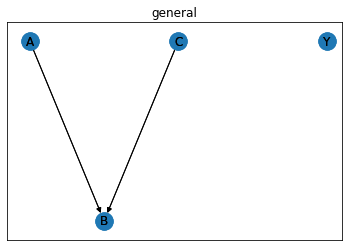

In [424]:
# trainer.py 

import torch
import torch.optim as optim
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

def plot_losses(loss_dict):

    plt.figure(figsize=(10,8))

    for key, values_list in loss_dict.items():
        plt.plot(values_list, label=key)

    # Add the legend to the plot
    plt.legend()
    plt.tight_layout()
    plt.savefig('losses.png')
    plt.close()

    
    
def train(train_data, val_data, max_iters, eval_interval, eval_iters, device, model, batch_size, save_iter,
          model_save_path, optimizer, start_iter=None, checkpointing_on=0):
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

    if start_iter == None:
        start_iter = 0
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,  max_iters//10, eta_min=1e-7, verbose=False)
    all_var_losses = {}
    for iter_ in range(start_iter, max_iters):
        # train and update the model
        model.train()

        xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


        if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
            for key in loss_dict.keys():
                if key not in all_var_losses.keys():
                    all_var_losses[key] = []
                all_var_losses[key].append(loss_dict[key])

            model.eval()
            eval_loss = {}
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):

                    xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                                   batch_size=batch_size)
                    xb_mod = torch.clone(xb.detach())
                    X, loss, loss_dict = model(X=xb, targets=xb_mod)
                    losses[k] = loss.item()
                eval_loss[split] = losses.mean()
            model.train()
            print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")


        if (iter_ > 1 ) and (iter_ != start_iter) and ((iter_ + 1) % save_iter == 0) and (checkpointing_on==1):
            print('Saving model checkpoint.')
            torch.save({
                'iteration': iter_,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, os.path.join(model_save_path, 'model_{}_{}.ckpt'.format(iter_+1, np.round(loss.item(), 2))))

    print('Finished training!')

    plot_losses(all_var_losses)
    
    
num_heads = 2
head_size = 5
n_layers = 2
ff_n_embed = 5  # number of channels/dimensions for the FF part of the block
batch_size = 1
validation_fraction = 0.2
learning_rate = 0.001
max_iters = 2
dropout_rate = 0.1
dataset = 'simple_test_v2'
sample_size = 100
seed = 1
device = 'cpu'
optimizer_name = "Adam"
eval_interval = 2
eval_iters = 5


_, _, _, _, Y0, Y1 = generate_data(N=sample_size, seed=seed, dataset=dataset, standardize=False)
ATE = (Y1 - Y0).mean()  # ATE based off a large sample

all_data, DAG, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, seed=seed, dataset=dataset)

indices = np.arange(0, len(all_data))
np.random.shuffle(indices)



val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data[train_inds]
val_data = all_data[val_inds]
print('Training data size:', train_data.shape, ' Validation data size:', val_data.shape)

input_dim = all_data.shape[2]


model = CaT(input_dim=input_dim, ff_n_embed=ff_n_embed, dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                dag=DAG,
                causal_ordering=causal_ordering,
                n_layers=n_layers,
                device=device,
                var_types_sorted=var_types,
                ).to(device)

initialize_model_weights(model)
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

In [425]:
# train() func
start_iter = None
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

if start_iter == None:
    start_iter = 0

all_var_losses = {}

for iter_ in range(start_iter, max_iters):
    model.train()
    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])
            
        model.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")


step 0 of 2: train_loss 1122381657538560.0000, val loss 1122381657538560.0000


In [410]:
a = np.array([[0., 0., 0. ,1.],
 [0., 0. ,0., 0.],
 [0., 0., 0. ,0.],
 [0., 0., 0. ,0.]])

In [379]:
b = np.array([[1,1,1],
 [2,2,2],
 [3,3,3],
 [4,4,4]])

In [383]:
a.T@b

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 1.]])

In [ ]:
train(train_data=train_data,
                      eval_iters=eval_iters,
                      val_data=val_data,
                      max_iters=max_iters,
                      eval_interval=eval_interval,
                      device=device,
                      model=model,
                      batch_size=batch_size,
                      save_iter=save_iter,
                      model_save_path=model_save_path,
                      optimizer=optimizer,
                      checkpointing_on=args.checkpointing_on
                      )

In [142]:
causal_ordering

{'A': 0, 'C': 0, 'Y': 0, 'B': 1}

In [143]:
a = nn.Linear(4,10)

In [16]:
xb.shape

torch.Size([1, 4, 10])

In [19]:
a(xb)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x10 and 4x10)